In [1]:
#IMPORTING LIBRARIES
import numpy as np
import matplotlib.pyplot as plt
import warnings
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Flatten, Dropout
import tensorflow as tf
import os
%matplotlib inline
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from IPython.display import SVG, Image

In [4]:
#read dataset
from tensorflow.keras.preprocessing.image import load_img, img_to_array
picture_size=128
folder_path = "D:\\Projects\\BRAIN TUMOR\\DATASET\\"
print(os.listdir(folder_path))

['test', 'train', 'valid']


In [5]:
for expression in os.listdir("D:\\Projects\\BRAIN TUMOR\\DATASET\\train"):
           print(str(len(os.listdir("D:\\Projects\\BRAIN TUMOR\\DATASET\\train\\"+expression)))+
           " "+expression+ ' images')

1400 no images
1400 yes images


In [6]:
#IMAGE DATA GENERATE
img_size=48
batch_size=64
datagen_train=ImageDataGenerator(horizontal_flip=True)
train_generator=datagen_train.flow_from_directory("D:\\Projects\\BRAIN TUMOR\\DATASET\\train",target_size=
(48,48), batch_size=batch_size, class_mode='categorical', shuffle=True)
datagen_validation=ImageDataGenerator(horizontal_flip=True)
validation_generator=datagen_train.flow_from_directory("D:\\Projects\\BRAIN TUMOR\\DATASET\\valid\\",target_size=
(48,48), batch_size=batch_size, class_mode='categorical', shuffle=True)

Found 2800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


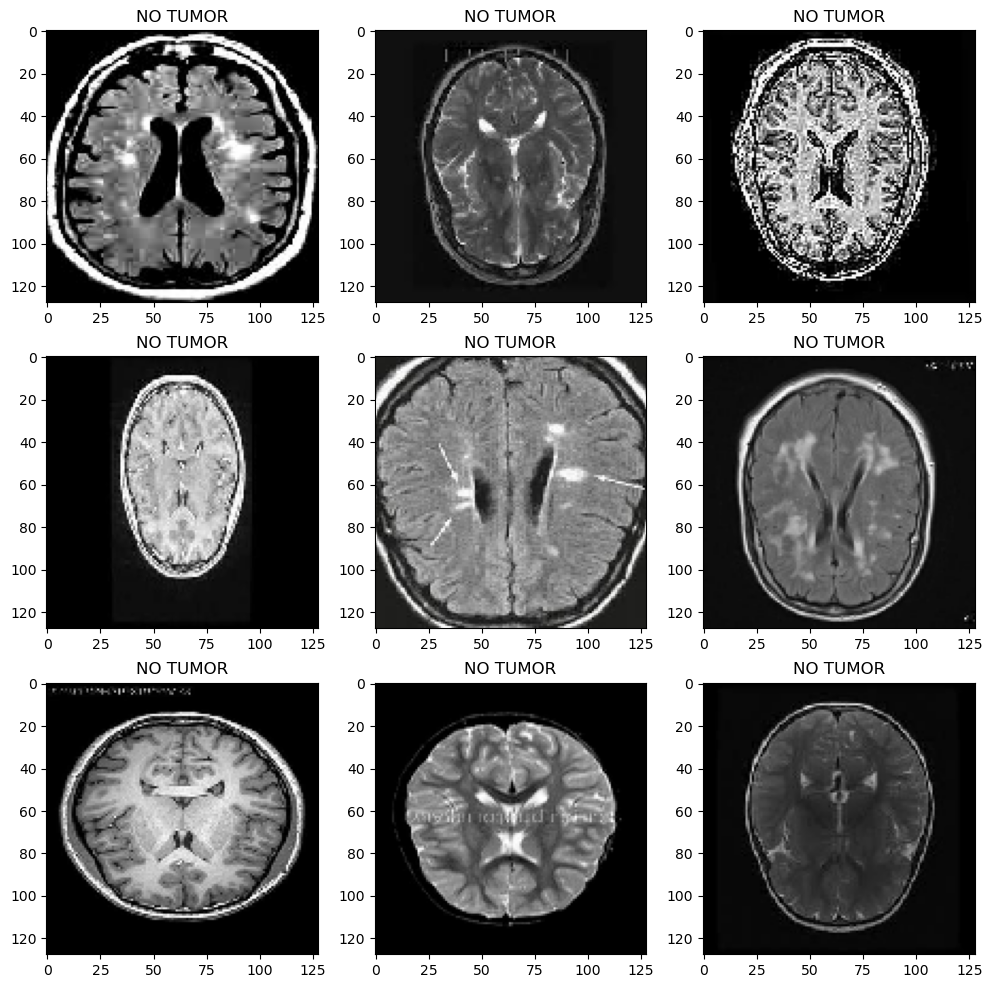

In [7]:
#NO TUMOR
expression = 'no'
plt.figure(figsize= (12,12))
for i in range(1, 10, 1):
    plt.subplot(3,3,i)
    img = load_img(folder_path+"Train/"+expression+"/"+
                  os.listdir(folder_path +"Train/" + expression)[i], target_size=(picture_size, picture_size))
    plt.title('NO TUMOR')
    plt.imshow(img)   
plt.show()

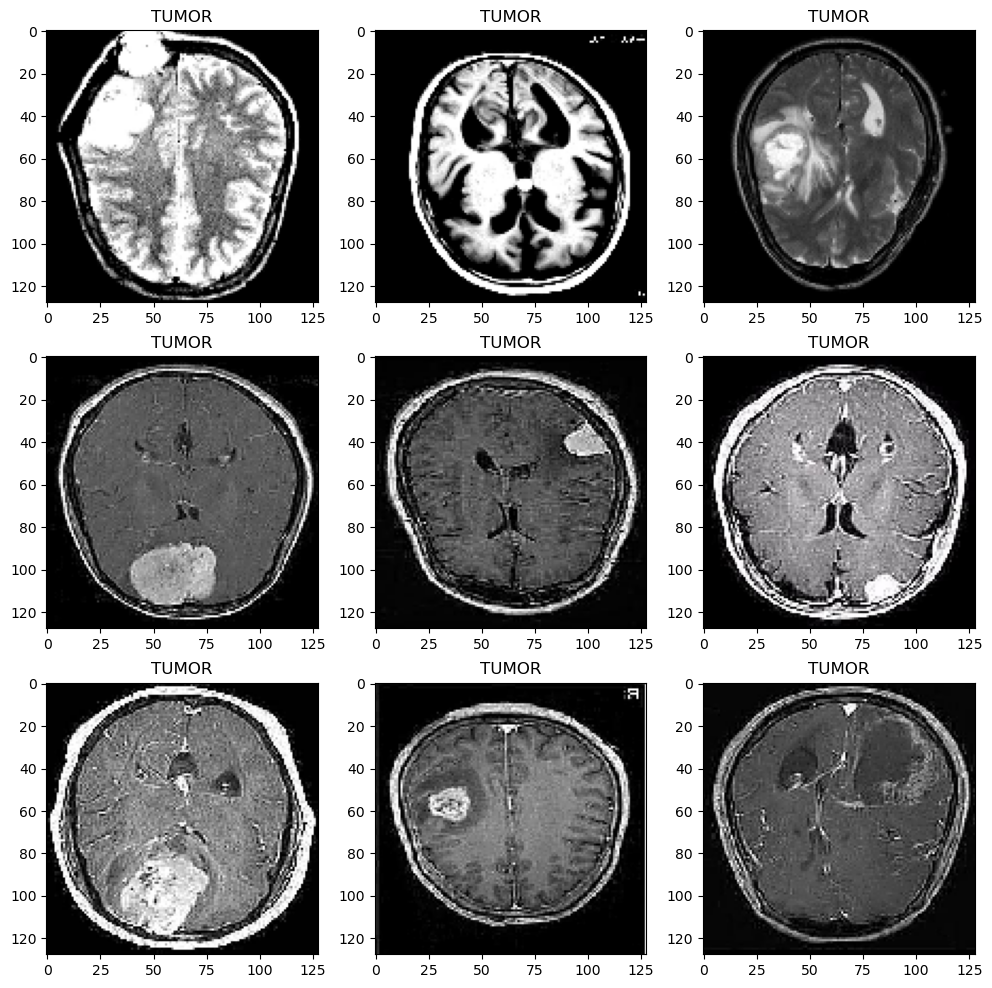

In [8]:
#TUMOR
expression = 'yes'
plt.figure(figsize= (12,12))
for i in range(1, 10, 1):
    plt.subplot(3,3,i)
    img = load_img(folder_path+"Train/"+expression+"/"+
                  os.listdir(folder_path +"Train/" + expression)[i], target_size=(picture_size, picture_size))
    plt.title('TUMOR')
    plt.imshow(img)   
plt.show()

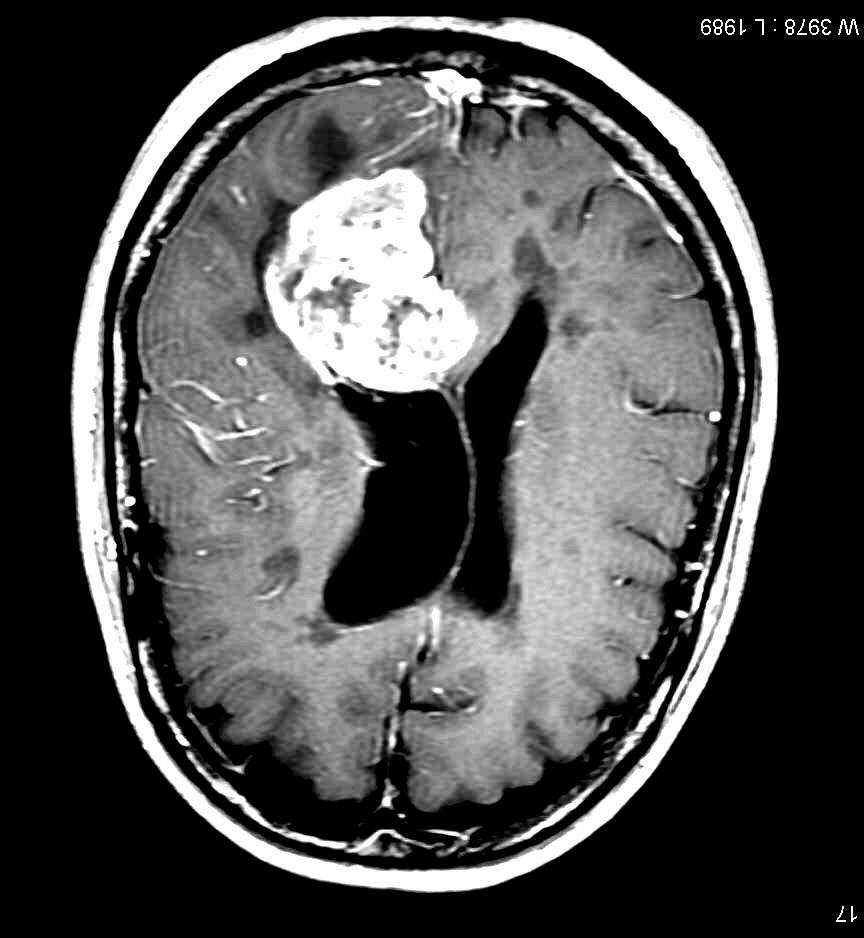

In [9]:
# MEDIAN FILTER
import numpy as np
import pandas as pd
from PIL import Image, ImageFilter
image_org = Image.open("D:\\Projects\\BRAIN TUMOR\\DATASET\\train\\yes\\y26.jpg")
def rgb2gray(rgb):
    if(len(rgb.shape) == 3):
        return np.uint8(np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140]))
    else:
        return rgb
image = np.array(image_org)
grayscale_image = rgb2gray(image)
def calculate_median(array):
    """Return the median of 1-d array"""
    sorted_array = np.sort(array)
    median = sorted_array[len(array)//2]
    return median
def level_A(z_min, z_med, z_max, z_xy, S_xy, S_max):
    if(z_min < z_med < z_max):
        return level_B(z_min, z_med, z_max, z_xy, S_xy, S_max)
    else:
        S_xy += 2 
        if(S_xy <= S_max):
            return level_A(z_min, z_med, z_max, z_xy, S_xy, S_max)
        else:
            return z_med
def level_B(z_min, z_med, z_max, z_xy, S_xy, S_max):
    if(z_min < z_xy < z_max):
        return z_xy
    else:
        return z_med
def amf(image, initial_window, max_window):
    xlength, ylength = image.shape
    z_min, z_med, z_max, z_xy = 0, 0, 0, 0
    S_max = max_window
    S_xy = initial_window
    
    output_image = image.copy()
    
    for row in range(S_xy, xlength-S_xy-1):
        for col in range(S_xy, ylength-S_xy-1):
            filter_window = image[row - S_xy : row + S_xy + 1, col - S_xy : col + S_xy + 1] 
            target = filter_window.reshape(-1)
            z_min = np.min(target)
            z_max = np.max(target)
            z_med = calculate_median(target) 
            z_xy = image[row, col]
            new_intensity = level_A(z_min, z_med, z_max, z_xy, S_xy, S_max)
            output_image[row, col] = new_intensity
        return output_image
output = amf(grayscale_image, 3, 11)
Image.fromarray(output)

In [10]:
# SEGMENTATION-K MEANS CLUSTERING
image=image_org.resize((320,225))
image=np.array(image)

In [11]:
im=image/255
pic=im.reshape(im.shape[0]*im.shape[1],im.shape[2])

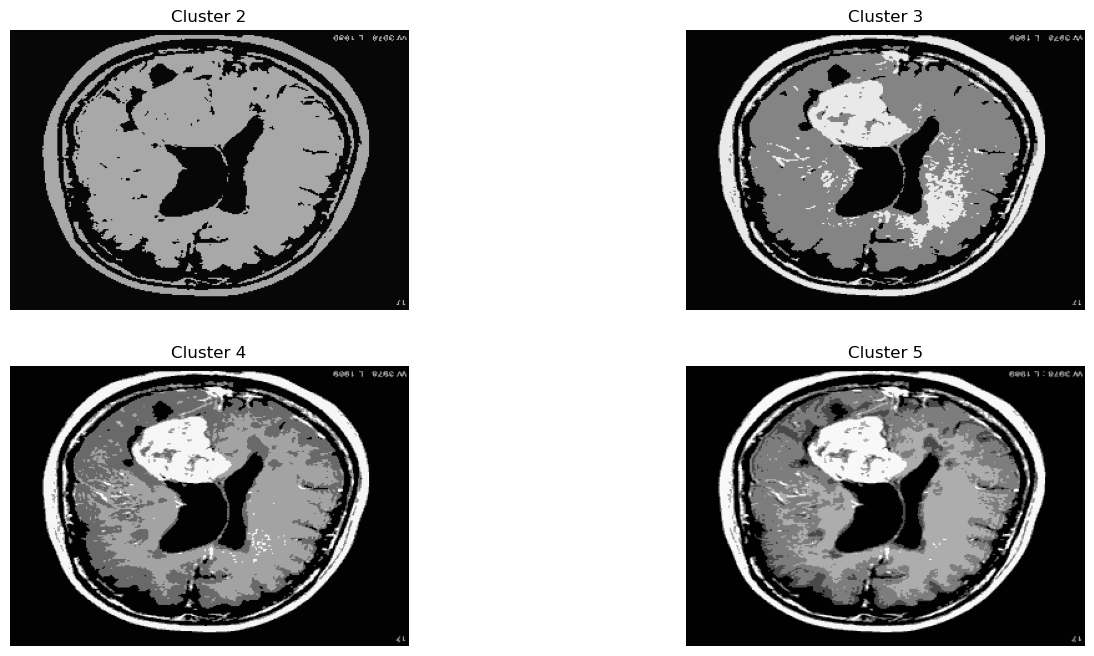

In [12]:
from sklearn.cluster import KMeans
warnings.simplefilter(action='ignore', category=FutureWarning)
fig, ax = plt.subplots(2, 2, figsize=(16, 8))
count=1
for i in range(2):
    for j in range(2):

        kmeans = KMeans(n_clusters=count+1, random_state=0).fit(pic)
        pic_print = kmeans.cluster_centers_[kmeans.labels_]
        clustered_pic=pic_print.reshape(im.shape[0],im.shape[1],im.shape[2])
        count+=1
        ax[i][j].set_title('Cluster '+str(count))
        ax[i][j].imshow(clustered_pic)
        ax[i][j].set_axis_off()
plt.show()

In [13]:
trainDataGen = ImageDataGenerator(rescale = 1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
trainingSet = trainDataGen.flow_from_directory("D:\\Projects\\BRAIN TUMOR\\DATASET\\train\\", target_size = (128, 128), batch_size = 32, class_mode = "binary")

Found 2800 images belonging to 2 classes.


In [14]:
trainingSet.class_indices

{'no': 0, 'yes': 1}

In [15]:
validDataGen = ImageDataGenerator(rescale = 1./255)
validSet = validDataGen.flow_from_directory("D:\\Projects\\BRAIN TUMOR\\DATASET\\valid\\", target_size = (128, 128), batch_size = 32, class_mode = "binary")

Found 200 images belonging to 2 classes.


In [16]:
# CNN
model = Sequential()
model.add(Conv2D(32, kernel_size = 3, input_shape=(128, 128, 3), activation ='relu', padding = 'Same'))
model.add(Conv2D(32, kernel_size = 3,  activation ='relu', padding = 'Same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = 2))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size = 3, activation ='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size = 3, activation ='relu', padding = 'Same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = 2, strides=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [17]:
model.compile(loss = "binary_crossentropy", optimizer='Adamax', metrics=["accuracy"])

In [18]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1

In [19]:
metricVals = model.fit(x = trainingSet, validation_data = validSet, epochs = 10, verbose = 2)

Epoch 1/10
88/88 - 292s - loss: 4.8218 - accuracy: 0.6646 - val_loss: 14.8930 - val_accuracy: 0.5000 - 292s/epoch - 3s/step
Epoch 2/10
88/88 - 266s - loss: 0.5509 - accuracy: 0.7564 - val_loss: 22.6195 - val_accuracy: 0.5000 - 266s/epoch - 3s/step
Epoch 3/10
88/88 - 270s - loss: 0.4583 - accuracy: 0.7893 - val_loss: 20.4750 - val_accuracy: 0.5000 - 270s/epoch - 3s/step
Epoch 4/10
88/88 - 265s - loss: 0.4239 - accuracy: 0.8104 - val_loss: 13.7570 - val_accuracy: 0.4850 - 265s/epoch - 3s/step
Epoch 5/10
88/88 - 265s - loss: 0.3710 - accuracy: 0.8393 - val_loss: 8.8308 - val_accuracy: 0.5050 - 265s/epoch - 3s/step
Epoch 6/10
88/88 - 359s - loss: 0.3503 - accuracy: 0.8514 - val_loss: 4.4816 - val_accuracy: 0.5850 - 359s/epoch - 4s/step
Epoch 7/10
88/88 - 413s - loss: 0.3209 - accuracy: 0.8707 - val_loss: 2.0354 - val_accuracy: 0.6250 - 413s/epoch - 5s/step
Epoch 8/10
88/88 - 299s - loss: 0.2846 - accuracy: 0.8736 - val_loss: 0.6377 - val_accuracy: 0.7400 - 299s/epoch - 3s/step
Epoch 9/10
8

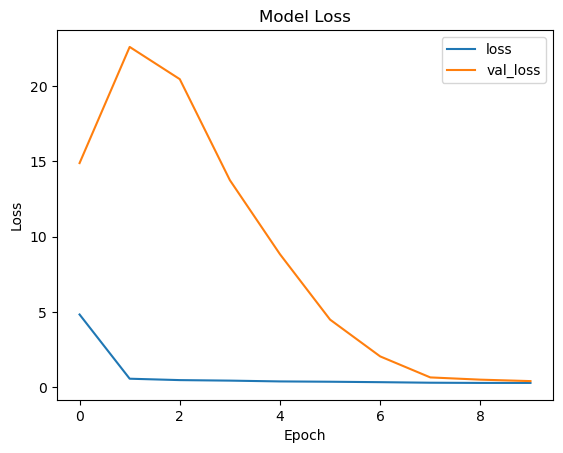

In [20]:
plt.plot(metricVals.history['loss'])
plt.plot(metricVals.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

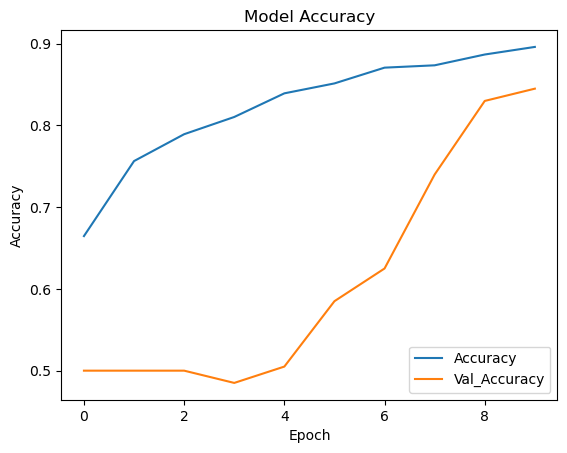

In [21]:
plt.plot(metricVals.history['accuracy'])
plt.plot(metricVals.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'Val_Accuracy'], loc='lower right')
plt.show()

In [22]:
model.save("BrainTumorClassifier.h5")

In [23]:
cnn = load_model("BrainTumorClassifier.h5")

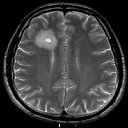

1/1 [==============================] - 0s 65ms/step
97.96475768089294 % chance of Brain Tumor.
Yes


In [38]:
# Yes 
from tensorflow.keras.preprocessing import image
path = "D:\\Projects\\BRAIN TUMOR\\DATASET\\test\\1.jpg"
test = image.load_img(path, target_size = (128, 128))
display(test)
test = image.img_to_array(test)
test = np.expand_dims(test, 0)
result = cnn.predict(test/255.0)
print("{} % chance of Brain Tumor.".format(result[0][0]*100))
if result[0][0] < 0.5:
    print("No")
else:
    print("Yes")

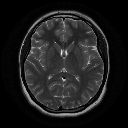

1/1 [==============================] - 0s 94ms/step
0.006513149855891243 % chance of Brain Tumor.
No


In [27]:
# NO
from tensorflow.keras.preprocessing import image
path = "D:\\Projects\\BRAIN TUMOR\\DATASET\\test\\3.jpeg"
test = image.load_img(path, target_size = (128, 128))
display(test)
test = image.img_to_array(test)
test = np.expand_dims(test, 0)
result = cnn.predict(test/255.0)
print("{} % chance of Brain Tumor.".format(result[0][0]*100))
if result[0][0] < 0.5:
    print("No")
else:
    print("Yes")

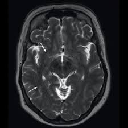

1/1 [==============================] - 0s 86ms/step
0.0024238053811131977 % chance of Brain Tumor.
No


In [37]:
# NO
from tensorflow.keras.preprocessing import image
path = "D:\\Projects\\BRAIN TUMOR\\DATASET\\test\\4.jpg"
test = image.load_img(path, target_size = (128, 128))
display(test)
test = image.img_to_array(test)
test = np.expand_dims(test, 0)
result = cnn.predict(test/255.0)
print("{} % chance of Brain Tumor.".format(result[0][0]*100))
if result[0][0] < 0.5:
    print("No")
else:
    print("Yes")

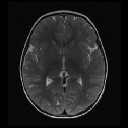

1/1 [==============================] - 0s 90ms/step
0.04847162344958633 % chance of Brain Tumor.
No


In [36]:
from tensorflow.keras.preprocessing import image
path = "D:\\Projects\\BRAIN TUMOR\\DATASET\\test\\2.jpeg"
test = image.load_img(path, target_size = (128, 128))
display(test)
test = image.img_to_array(test)
test = np.expand_dims(test, 0)
result = cnn.predict(test/255.0)
print("{} % chance of Brain Tumor.".format(result[0][0]*100))
if result[0][0] < 0.5:
    print("No")
else:
    print("Yes")

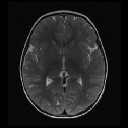

1/1 [==============================] - 0s 77ms/step
0.04847162344958633 % chance of Brain Tumor.
No


In [35]:
from tensorflow.keras.preprocessing import image
path = "D:\\Projects\\BRAIN TUMOR\\DATASET\\test\\2.jpeg"
test = image.load_img(path, target_size = (128, 128))
display(test)
test = image.img_to_array(test)
test = np.expand_dims(test, 0)
result = cnn.predict(test/255.0)
print("{} % chance of Brain Tumor.".format(result[0][0]*100))
if result[0][0] < 0.5:
    print("No")
else:
    print("Yes")

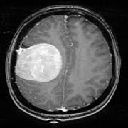

1/1 [==============================] - 0s 78ms/step
99.77338314056396 % chance of Brain Tumor.
Yes


In [32]:
from tensorflow.keras.preprocessing import image
path = "D:\\Projects\\BRAIN TUMOR\\DATASET\\test\\5.jpg"
test = image.load_img(path, target_size = (128, 128))
display(test)
test = image.img_to_array(test)
test = np.expand_dims(test, 0)
result = cnn.predict(test/255.0)
print("{} % chance of Brain Tumor.".format(result[0][0]*100))
if result[0][0] < 0.5:
    print("No")
else:
    print("Yes")